In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
import numpy as np
import os

## Select base model to apply transfer learning to 
<table style="border: 0px; width: 100%;">
  <th style="border: 0px">
    <tr style="border: 0px; font-weight: bold">
      <td style="border: 0px">Model Name</td>
      <td style="border: 0px">Input Size</td>
      <td style="border: 0px">Data Range</td>
      <td style="border: 0px">Total Params</td>
    </tr>
  </th>
  <tbody>
    <tr style="border: 0px">
      <td style="border: 0px">InceptionResNet2</td>
      <td style="border: 0px">299x299x3</td>
      <td style="border: 0px">-1, 1</td>
      <td style="border: 0px">56M</td>
    </tr>
    <tr style="border: 0px">
      <td style="border: 0px">Xception</td>
      <td style="border: 0px">150x150x3</td>
      <td style="border: 0px">-1, 1</td>
      <td style="border: 0px">23M</td>
    </tr>
    <tr style="border: 0px">
      <td style="border: 0px">Resnet101V2</td>
      <td style="border: 0px">224x224x3</td>
      <td style="border: 0px">-1, 1</td>
      <td style="border: 0px">45M</td>
    </tr>
    <tr style="border: 0px">
      <td style="border: 0px">Resnet50V2</td>
      <td style="border: 0px">224x224x3</td>
      <td style="border: 0px">-1, 1</td>
      <td style="border: 0px">24M</td>
    </tr>
  </tbody>
  
</table>

In [2]:
image_shape = (224, 224, 3)
base_model = keras.applications.ResNet152V2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=image_shape,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

### Define random data augmentation function

In [3]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1), layers.RandomZoom(0.1)], 
    name="data_augmentation"
)

In [4]:
# Create new model on top
inputs = keras.Input(shape=image_shape, name="image_input")
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Inception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1, name="rescale")
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D(name="global_pool")(x)
x = keras.layers.Dropout(0.2, name="dropout_regularisation")(x)  # Regularize with dropout
x = layers.Dense(200, activation="relu", name="feature_vector")(x) # For shallow feature extraction
outputs = keras.layers.Dense(3, name="classification")(x)  # Number of emotions to be predicted 
model = keras.Model(inputs, outputs, name="AffectNN")
model.summary()

Model: "AffectNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ image_input (InputLayer)        │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ rescale (Rescaling)             │ (None, 224, 224, 3)       │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)        │ 23,564,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ global_pool                     │ (None, 2048)              │          0 │
│ (GlobalAveragePooling2D)        │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dropout_regularisation          │ (None, 2048)              │          0 │
│ (Dropout)                       │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ feature_vector (Dense)          │ (None, 200)               │    409,800 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ classification (Dense)          │ (None, 3)                 │        603 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 23,975,203 (91.46 MB)

 Trainable params: 410,403 (1.57 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

# Import the dataset to train the images

In [5]:
base_path_structured = "/Users/benhoskings/Documents/Datasets/FusionV2"
train_path_structured = os.path.join(base_path_structured, "train_set")

class_names = ["Negative", "Neutral", "Positive"]
# class_names = ["Anger", "Disgust", "Happy", "Neutral", "Fear", "Sad", "Surprise"]
batch_size = 128

train_ds = keras.utils.image_dataset_from_directory(
    train_path_structured, 
    class_names=class_names,
    label_mode="categorical", 
    labels="inferred",
    batch_size=batch_size,
    image_size=image_shape[0:2],
    seed=101)

val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(base_path_structured, "val_set"), 
    class_names=class_names,
    label_mode="categorical", 
    labels="inferred",
    batch_size=batch_size,
    image_size=image_shape[0:2],
    seed=101)

Found 235695 files belonging to 3 classes.
Found 1500 files belonging to 3 classes.


## Display a selectio of the images, with their labels

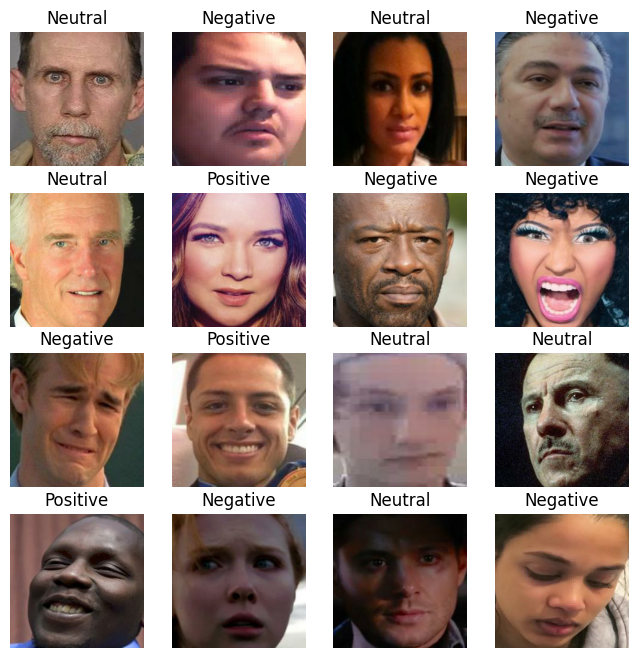

In [6]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")

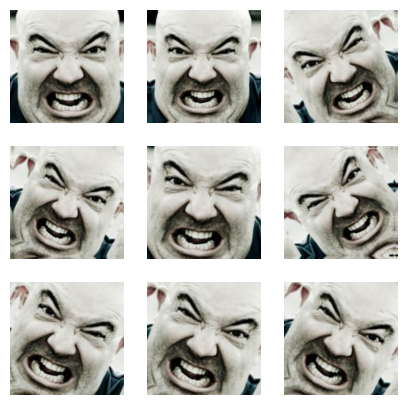

In [7]:
plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1).cache():
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.axis("off")

In [8]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
validation_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [9]:
# SPECIFY LEARNING RATE
base_learning_rate = 0.005

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy()],
)

total_epochs = 4

In [10]:
checkpoint_filepath = '/Users/benhoskings/Documents/Pycharm/Hero_Monitor/affective_computing/data/checkpoints/checkpoint.keras'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_categorical_accuracy',
    mode='max',
    save_best_only=True, 
    save_freq="epoch")

In [11]:
def edit_trainable_layers(count,  mod):
    mod.trainable = True
    for layer in mod.layers[:len(mod.layers) - count]:
      layer.trainable = False
        
    print("Number of trainable variables in the base model: ", len(mod.trainable_variables))

In [ ]:
edit_trainable_layers(10, model)
train_history = model.fit(train_ds, shuffle=True, epochs=total_epochs, 
                          validation_data=validation_ds,
                          callbacks=[model_checkpoint_callback])

Number of trainable variables in the base model:  4
Epoch 1/4
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 38580s 21s/step - categorical_accuracy: 0.5866 - loss: 0.5454 - val_categorical_accuracy: 0.6600 - val_loss: 0.4628
Epoch 2/4
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 9472s 5s/step - categorical_accuracy: 0.6388 - loss: 0.4733 - val_categorical_accuracy: 0.6607 - val_loss: 0.4536
Epoch 3/4
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 10337s 6s/step - categorical_accuracy: 0.6464 - loss: 0.4652 - val_categorical_accuracy: 0.6540 - val_loss: 0.4523
Epoch 4/4
 869/1842 ━━━━━━━━━━━━━━━━━━━━ 1:46:28 7s/step - categorical_accuracy: 0.6475 - loss: 0.4629

In [ ]:
acc = train_history.history['categorical_accuracy']
val_acc = train_history.history['val_categorical_accuracy']

loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

epochs_range = range(total_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
base_rate = 1e-3
layer_counts = [10, 20, 30, 40, 50, 60]
rates = [1e-4, 5e-5, 1e-5]
epochs = [3 for _ in layer_counts]


    
for l_count, epoch, rate in zip(layer_counts, epochs, rates):
    edit_trainable_layers(l_count, base_model)
        
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=rate),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.CategoricalAccuracy()],
    )
    
    total_epochs += epoch
    
    train_history = model.fit(train_ds,
                             epochs=total_epochs,
                             initial_epoch=train_history.epoch[-1],
                             validation_data=val_ds,
                             callbacks=[model_checkpoint_callback])
    
    acc += train_history.history['categorical_accuracy']
    val_acc += train_history.history['val_categorical_accuracy']
    
    loss += train_history.history['loss']
    val_loss += train_history.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([2,2], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([2,2], plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig('training_plot.png')
plt.show()

In [ ]:
img = keras.utils.load_img("sample_images/Fear.png", target_size=image_shape[:2])

img_array = keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

In [ ]:
import pickle
model.save("data/AffectInceptionResNetV4.keras")
with open('data/train_history.pickle', 'wb') as file_pi:
    pickle.dump([train_history.epoch, acc, val_acc, loss, val_loss], file_pi)

In [ ]:
print([train_history.epoch, acc, val_acc, loss, val_loss])